# Classically-Boosted Variational Quantum Eigensolver

One of the most important applications of quantum computers is expected to be the computation of ground-state energies of complicated molecules and materials. Even though there are already some solid proposals on how to tackle these problems when fault-tolerant quantum computation becomes a reality, right now we live in the [`NISQ`](https://en.wikipedia.org/wiki/Noisy_intermediate-scale_quantum_era) era, where we can only access very noisy and limited devices. A large part of the research on quantum algorithms is focusing on what can be done for now with few resources. In particular, most of the proposals of the field rely on variational quantum algorithms that adapt to the limitations of the devices.  They can be optimised classically. For the specific problem of computing ground-state energies, this reduces to the very well-known Variational Quantum Eigensolver (VQE) algorithm.

[add picture-drawing VQE vs FT]

Although VQE is intended to run on NISQ devices, it is nonetheless sensitive to noise. This is in particular problematic when applying a large number of gates. As a consequence, many different modifications to the original VQE algorithm have been proposed. These modifications are usually intended to improve the algorithm's performance on NISQ-era devices. 

We will go through one of these proposals step-by-step: the Classically-Boosted Variational Quantum Eigensolver (CB-VQE), which was recently proposed in this [`paper`](https://arxiv.org/abs/2106.04755). This variant of VQE allows us to reduce the number of measurements required to obtain the ground-state energy with a certain precision by making use of classical states. Classical states already contain some information about the ground-state of the problem. 
For the sake of simplicity, we will restrict ourselves to the $H_2$ molecule. In this demo we will: 

- give a short introduction on how to perform standard VQE for the molecule of interest. For more details, we recommend the following [`demo`](https://pennylane.ai/qml/demos/tutorial_vqe.html) to learn how to implement VQE for molecules step-by-step.
- implement the CB-VQE algorithm for the specific case in which we rely only on one classical state, that being the Hartree-Fock state.
- discuss the number of measurements needed to obtain a certain error-threshold 

[add picture-drawing]

## Prequisites: Standard VQE

If you are not already familiar with the VQE family of algorithms and wish to see how one can apply it the $H_2$ molecule, feel free to work through [VQE overview demo](https://pennylane.ai/qml/demos/tutorial_vqe.html). We will briefly review the main idea behind standard VQE and also apply it to the $H_2$ molecule with the *STO-3G basis* from PennyLane with $M=2$ active orbitals for $N=2$ electrons. 
The main goal of VQE is to find the ground energy of the Schrödinger equation $H \vert \phi \rangle = E  \vert \phi \rangle$ which corresponds to finding the smallest eigenvalue. An equivalent formulation is to minimize the energy $E = \langle \phi \vert H \vert \phi \rangle$ which acts as a cost function.
The statevector $\vert \phi \rangle$ is prepared by applying a given parameterized ansatz $A(\Theta)$ to the inital state $\vert 0^N \rangle$. The parameters are optimized using classical methods, e.g. we could minimize 
$$
E(\Theta) = \langle 0^{N} \vert A(\Theta)^{\dagger} H A(\Theta) \vert 0^{N} \rangle
$$
with gradient descent. 
For the ansatz $A(\Theta)$ we choose a circuit comprising of *Givens rotations* $G(\Theta)$ (TODO::Is nomenclature correct for higher order excatations?) and $X$-operations. The *Pauli* operations are applied in order to initalize the *Hartree-Fock* state $\vert HF \rangle=\vert 1 \cdots 1 0 \cdots 0 \rangle = X \otimes \cdots \otimes X \otimes I \otimes \cdots \otimes I \vert 0^N\rangle$.
A *Givens rotation* gate physically corresponds to the excitation of a certain number of electrons. 
For now we will focus on single and double excitation gates $G^{(1, 2)}(\Theta)$ which are conveniently implemented in PennyLane with [`SingleExcitation`](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.SingleExcitation.html) and [`DoubleExcitation`](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.DoubleExcitation.html) classes. 
The [`AllSinglesDoubles`](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.AllSinglesDoubles.html?highlight=allsinglesdoubles#pennylane.AllSinglesDoubles) class enables us to apply all possible combinations of single and double excitations, which obey the Pauli principle, to the *Hartree-Fock* state. 

3
Step = 0,  Energy = -1.12938909 Ha
Step = 10,  Energy = -1.13305558 Ha
Step = 20,  Energy = -1.13863234 Ha
Step = 30,  Energy = -1.13422763 Ha
Step = 40,  Energy = -1.14189515 Ha

Final value of the ground-state energy = -1.13355418 Ha

Optimal values of the circuit parameter =,  [0.00148142 0.002551   0.20550265]


Text(0, 0.5, 'energy (Ha)')

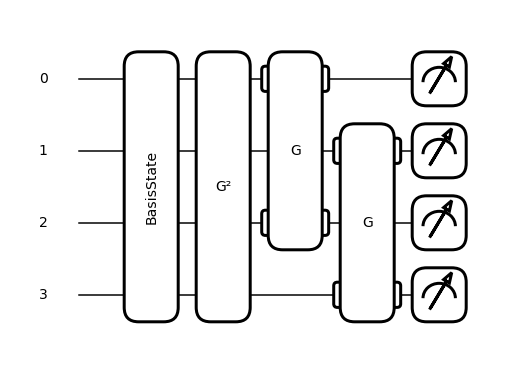

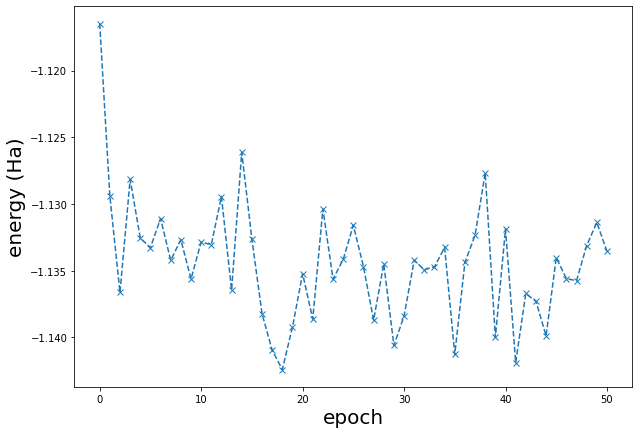

In [16]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

# Define the molecular Hamiltonian
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])

basis_set = "sto-3g"
electrons = 2
orbitals = 2

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Define the HF initial state
hf = qml.qchem.hf_state(electrons, qubits)

# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)
print(num_theta)
 
# Define a device
dev = qml.device('default.qubit', wires=qubits, shots=1024)

# Define the cost function and the circuit
def circuit(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)

@qml.qnode(dev)
def cost_fn(theta):
    circuit(theta,range(qubits)) # Why define outside?
    return qml.expval(H)

# Draw circuit
qml.drawer.use_style('black_white')
qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

# Gradient descent optimization
opt = qml.GradientDescentOptimizer(stepsize=0.4)
theta = np.zeros(num_theta, requires_grad=True)

#  Initial energy
energy = [cost_fn(theta)]
angle = [theta]

# Set the number of iterations
num_iterations = 50

for n in range(num_iterations):

    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    if n % 10 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

from matplotlib import pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(energy ,"x--")
plt.xlabel("epoch", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

## Classically-Boosted VQE

Now we are ready to present the classically-boosted version of VQE. The key of this new method relies on the notion of [`generalized eigenvalue problem`](https://en.wikipedia.org/wiki/Generalized_eigenvalue_problem). The main idea is to restrict the problem of finding the ground state to an eigenvalue problem to a subspace $\mathcal{H}^{\prime}$ of the complete Hilbert space $\mathcal{H}$. If this subspace is spanned by a combination of both classical and quantum states, we can run parts of our algorithm on classical hardware and thus reduce the number of measurements needed to reach a certain precision threshold. 

Let's first introduce the so-called generalized eigenvalue problem. It is similar to the normal eigenvalue problem with the exception that it may only be defined on some subspace instead the whole vectorspace. We define this subspace as the span of $\{\vert \phi_\alpha \rangle\}_\alpha$. The generalised eigenvalue problem can be expressed as 
$$
\bar{H} \vec{v}=  \lambda \bar{S} \vec{v},
$$
where $\bar{H}$ is the Hamiltonian $H$ represented in terms of the spanning set $\{\vert \phi_\alpha \rangle\}_\alpha$ states, i.e. with the entries
$$
\bar{H}_{\alpha, \beta} = \langle \phi_\alpha \vert H \vert \phi_\beta \rangle.
$$

The matrix $\bar{S}$ contains the overlaps between the basis states. For a complete orthonormal basis, the overlap matrix $\hat{S}$ would simply be the identity matrix. However, we need to take a more general approach which works for a subspace spanned by potentially non-orthogonal states. We can retrieve the representation of $S$ in terms of $\{\vert \phi_\alpha \rangle\}_\alpha$ by calculating 
$$
\bar{S}_{\alpha, \beta} = \langle \phi_\alpha \vert \phi_\beta \rangle \quad \forall \alpha, \beta.
$$

Note that $\vec{v}$ and $\lambda$ are the eigenvectors and eigenvalues respectively. In particular, our goal is to find the lowest eigenvalue $\lambda_0$. 

Equipped with the useful mathematical description of generalised eigenvalue problems, we can now choose our subspace such that some of the states $\phi_{\alpha} \in \mathcal{H}^{\prime}$ are classically tractable. We define these states to have the property that both $\bar{S}_{\alpha, \beta}$ and $\bar{H}_{\alpha, \beta}$ can be evaluated efficiently on a classical computer [TODO:CITE]. We consider the simplest case in which the subspace is spanned only by one classical state $\vert \phi_{HF} \rangle$ and one quantum state $\vert \phi_{q} \rangle$. More precisely, we define the classical state to be a single [`Slater determinant`](https://en.wikipedia.org/wiki/Slater_determinant), which directly hints towards using the Hartree-Fock state for several reasons. First of all, it is well-known that the Hartree-Fock state is a good candidate to approximate the ground state in the mean-field limit. Secondly, we already compute it when we build the molecular Hamiltonian for the standard VQE!

To summarize, our goal is to build the hamiltonian $\bar{H}$ and the overlap matrix $\bar{S}$, which act on the subspace $\mathcal{H}^{\prime} \subseteq \mathcal{H}$ spanned by $\{\vert \phi_{HF} \rangle, \vert \phi_q \rangle\}$. These will be two-dimensional matrices, and in the following Sections we will show how to compute all their entries step by step.

As done previously, we start by importing *PennyLane*, *Qchem* and differentiable *NumPy* followed by  defining the molecular hamiltonian in the Hartree-Fock basis for $H_2$.


In [17]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
basis_set = "sto-3g"
electrons = 2
orbitals = 2

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

hf = qml.qchem.hf_state(electrons, qubits)

### Computing Classical Quantities

We first set out to calculate the purely classical part of the Hamiltonian $H$. Since we only have one classical state this will already correspond to a scalar energy value. The terms can be expressed as 
$$
H_{11} = \langle \phi_{HF} \vert H \vert \phi_{HF} \rangle \quad \text{and} \quad S_{11} = \langle \phi_{HF} \vert \phi_{HF} \rangle
$$
which is tractable using classical methods. This energy corresponds to the Hatree-Fock energy due to our convenient choice of the classical state. Note that the computation of the classical compononent of the overlap matrix $S_{11} = \langle \phi_{HF} \vert \phi_{HF} \rangle = 1$ is trivial. 
This energy can be computed using your classical method of choice. We will just implement this part of the code as a *PennyLane* circuit for now. This can be done with the help of the `qml.BasisState` function. [TODO:Check if we can actually calculate classically].

In [18]:
dev11 = qml.device('default.qubit', wires=qubits, shots=1024)

@qml.qnode(dev11)
def circuit_H11():
    qml.BasisState(hf, wires=range(qubits))
    return qml.expval(H)

H11 = circuit_H11()

Note running this circuit on a quantum device would definitely not be the most efficient way to compute this expectation value! We just use this functionality in PennyLane because our molecular Hamiltonian is already built in the qubit basis, but we could run the circuit classically.

### Computing Quatum Quantities

We now move on to the purely quantum part of the Hamiltonian, i.e. the entry 
$$
H_{22} = \langle \phi_{q} \vert H \vert \phi_{q} \rangle,
$$
where $\vert \phi_q \rangle$ is the quantum state.  This state is just the output of a standard VQE with a given ansatz, following the steps in the first Section. Therefore the entry $H_{22}$ just corresponds to the final energy of the VQE. In particular, note that the quantum state can be written as $\vert \phi_{q} \rangle = A(\theta^*) \vert \phi_{HF} \rangle$ where $A(\theta^*)$ is the ansatz of the VQE with the optimised parameters $\theta^*$. We once again have $S_{22}=\langle \phi_{q} \vert \phi_{q} \rangle = 1$ for the overlap matrix. 

### Computing Mixed Quantities

The final, and most difficult to compute, term is the cross-term between the classical and quantum state. We can express it as 
$$
H_{12} = \langle \phi_{HF} \vert H \vert \phi_{q} \rangle = H_{21}^{\dagger}.
$$
This part of the algorithm is slightly more complicated than the previous steps, since we still want make use of the classical component of the problem in order to minimise the number of required shots. 
Keep in mind that most algorithms usually perform computations either on fully classically or quantum tractable Hilbert spaces. CB-VQE takes advantage of the classical part of the problem while still calculating a classically-intractable quantity by using the so-called [`Hadamard test`](https://en.wikipedia.org/wiki/Hadamard_test_(quantum_computation)) to construct $H_{12}$. The Hadamard test is a prime example of an indirect measurement. An indirect measurement allows us to measure properties of a state without (completely) destroying it [TODO:Cite]. In the case of the Hadamard test we can calculate the real part of $\langle \phi \rvert U \rvert \phi \rangle$ for some unitary $U$. We can also retrieve the imaginary part if we use a different initial state.[TODO:INSERT IMAGE OF HADAMARD TEST CIRCUIT]
It consists of the state to be projected on - which we labelled as $\rvert \phi \rangle$ - and an ancillary system prepared in the $\rvert 0 \rangle$ state. In the algorithm, a controlled version of the unitary $U$ is used. The ancilla qubit acts as the control. Two hadamard gates - one before and one after the control operation - are also applied to the ancillary system. 
In order to calculate $\langle \phi_{HF} \vert \phi_{q} \rangle$, we can choose $U$ such that $U\vert \phi_{q} \rangle = \vert \phi_{HF} \rangle$. 
To be able to calculate $H_{12}$, we must first decompose the hermitian operator into unitaries. Assuming we can write our Hamiltonian as $H = \sum_{l} h_{l}$, where $h_{l}$ is unitary, we simply apply the Hadamard test to $h_{l}$. 

In [19]:
wires = range(qubits + 1)
dev_a = qml.device("default.qubit", wires=wires)

def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf,
        singles = singles,
        doubles = doubles)

def circuit_HF():
    for wire in range(electrons):
        qml.PauliX(wires=wire)
    for wire in range(electrons, qubits):
        qml.Identity(wires=wire)    
    
theta_opt = theta
Vcl = np.identity(2**qubits)
Vq = qml.matrix(circuit_VQE)(theta_opt, range(qubits))
W = qml.matrix(circuit_HF)()

@qml.qnode(dev_a)
def hadamard_test(Vq, Vcl, W, component='real'):
    
    if component == 'imag':
        qml.RX(math.pi/2, wires=a_wires)
    
    qml.Hadamard(wires=[0])
    qml.QubitUnitary(W, wires=wires[1:])
    qml.ControlledQubitUnitary(Vq.conjugate().T @ Vcl, control_wires=[0], wires=wires[1:])
    qml.Hadamard(wires=[0])
    
    return qml.probs(wires=[0])

probs = hadamard_test(Vq, Vcl, W)
y = 2*probs-1

<span style="color:red">(Now I compute the Hamiltonian and S crossed entries (eq. 11 and 12 of the paper). But I am not entirely sure I am doing eq. 11 correctly, actually here I think I am missing something. What are the computational basis states?? It seems to me that i0 is the HF state, and also we only have two y_i, but then what is i1?? It cannot be the quantum state or we are back to the same. Let me know if you undersand this part... )</span>.

In [20]:
H12 = y[0]*H11 + y[1]
H21 = np.conjugate(H12)

S = np.array([[1, y[0]],[y[0], 1]])
H = np.array([[H11, H12],[H21, H22]])

NameError: name 'H22' is not defined

In [ ]:
### S-matrix

### Calculating the Result

Finally, we solve the generalized eigenvalue problem.

In [ ]:
from scipy import linalg
evals = linalg.eigvals(H, S)
print('GS energy: ', evals[1])

## DISCUSSION ON THE NUMBER OF MEASUREMENTS GIVEN A FIXED OVERLAP AND PRECISION

Now, the goal of the paper is actually estimating the number of measurements needed to obtain a fixed variance in the energies for both VQE and CB VQE.

For doing this, we need to expand the variance of the eigenvalues and obtain an expression in terms of the overlaps. Then, if we fix a precision of $1 mHa$, what is the number of measurements needed?

The ration between them will be the speed up that we obtain.

linalg.eigvals(H, S)

<span style="color:red">(This part is totally missing. Mmhhh I was thinking we could compute something using the measurement implemented in pennylane qml.var(), which directly gives you the variances. I will try to check next week!)</span>.